# Notes

Several testing procedures that have been done and need to do

1. we set `horizontal_flip=False`


2. we removed image_augmentation and set it to the input image shape of MobileNetV2 which is (224, 224). See [Q. Xiang, 2019]


3. we changed the optimizer from RMSprop to Adam. See [Q. Xiang, 2019]


4. we want to use the following model (from [Q. Xiang, 2019])

    - mobilenetv2_1.00_224 (the base model)
    
    - conv2d (Conv2D) with the 32 filters and 5x5 windows
    
    - droput (Dropout) with the rate: {0.1, 0.2, 0.3, 0.4} 
    
    - global_average_pooling2d
    
    - dense (Softmax)
 
 
5. Hypertuning parameter to find the best parameters for learning_rate and dropout_rate.

## References

Q. Xiang, et.al., (2019) *Fruit Image Classification Based on MobileNetV2 with Transfer Learning Technique*, https://doi.org/10.1145/3331453.3361658

In [1]:
import os
import sys
import random
import shutil
import time
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras_preprocessing import image as keras_prep_image

In [2]:
tf.__version__

'2.2.0'

# Data preprocessing

## Directories preparation and shuffling

We will copy the original data and put it into three main categories: training (`train`), validation (`val`), and testing (`test`).

In [3]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
src_data_dir = os.getcwd() + '/DataSet Signos'      
dest_data_dir = os.getcwd() + '/DataSet Signos splitted'

recopy_state = True

train_dir = os.path.join(dest_data_dir,'train')     
val_dir = os.path.join(dest_data_dir,'validation') 
test_dir = os.path.join(dest_data_dir,'test')  

splitting_ratio = [.7, .2, .1]
train_size, val_size, test_size = splitting_ratio    # Portion of Split (0-1)

if sum(splitting_ratio) > 1.0:
    print(f"Cummulative data split portion out of maximum range (>1)")    
    raise StopExecution

    
# extract raw information
label = {letter: len(os.listdir(os.path.join(src_data_dir, letter))) 
         for letter in os.listdir(src_data_dir)}
count = sum(val for val in label.values())

for DIR, number in label.items():
    print(f"Number of images in directory {DIR} is {number}")


# generate subdirectories for dataset
print("")
try:
    for data_dir in [train_dir, val_dir, test_dir]:
        for letter in list(label.keys()):
            os.makedirs(os.path.join(data_dir, letter))
    print(f"Tree directories for letters have been created")    
except  FileExistsError:
    print(f"Tree directories for letters are existed")
    if recopy_state:
        for data_dir in [train_dir, val_dir, test_dir]:
            shutil.rmtree(data_dir)
            for letter in list(label.keys()):
                os.makedirs(os.path.join(data_dir, letter))
        print(f"Tree directories for letters have been created") 
        

# shuffle-split and copy data into directories
for DIR in os.listdir(src_data_dir):
    src_link = os.path.join(src_data_dir, DIR)
    dest_link = os.path.join(dest_data_dir, DIR)
    dataset = os.listdir(src_link)
    random.shuffle(dataset)
    
    num = label[DIR]
    
    train_length = int(train_size*num)
    val_length = int(val_size*num)
    test_length = int(test_size*num)
    
    train_directory = os.path.join(train_dir, DIR)
    val_directory = os.path.join(val_dir, DIR)
    test_directory = os.path.join(test_dir, DIR)
    
    if test_length != 0:
        train = dataset[:train_length]
        val = dataset[train_length : (val_length + train_length)]
        test = dataset[(val_length + train_length) : ] 
        for k in test:
            source_test = os.path.join(src_link, k)
            destination_test = os.path.join(test_directory, k)
            shutil.copyfile(source_test, destination_test)
    else:
        train = dataset[:train_length]
        val = dataset[train_length:] 
            
    for i in train:
        source_train = os.path.join(src_link, i)
        destination_train = os.path.join(train_directory, i)
        shutil.copyfile(source_train, destination_train)
    
    for j in val:
        source_val = os.path.join(src_link, j)
        destination_val = os.path.join(val_directory, j)
        shutil.copyfile(source_val, destination_val)

Label = {}  # Splitting Dataset Label
Count = {}  # Number of Split Data
for DIR in os.listdir(dest_data_dir):
    c = 0
    directory = os.path.join(dest_data_dir, DIR)
    for subdir in os.listdir(directory):
        sub_dir = os.path.join(directory, subdir)
        number = len(os.listdir(sub_dir))
        Label[DIR+'_'+subdir] = number
        c += number
    Count[DIR] = c
    
train_len = Count['train']
test_len = Count['test']
val_len = Count['validation']

print(f'\nLabel of original data :\n{list(label.keys())}\n')
print(f'Total images in original dataset                    : {count}\n')
print(f'Total dataset after and before split                : {sum(Count.values()),count}\n')
print(f'Total numbers of training, validation, testing data : {train_len, val_len, test_len}')

Number of images in directory L is 72
Number of images in directory R is 65
Number of images in directory Y is 58
Number of images in directory O is 85
Number of images in directory T is 56
Number of images in directory W is 54
Number of images in directory P is 86
Number of images in directory U is 57
Number of images in directory X is 51
Number of images in directory S is 52
Number of images in directory K is 74
Number of images in directory V is 57
Number of images in directory E is 155
Number of images in directory A is 63
Number of images in directory M is 71
Number of images in directory H is 71
Number of images in directory B is 78
Number of images in directory F is 84
Number of images in directory D is 73
Number of images in directory I is 74
Number of images in directory Q is 69
Number of images in directory C is 131
Number of images in directory N is 67
Number of images in directory G is 85

Tree directories for letters are existed
Tree directories for letters have been creat

Show several images from the training set.

Dataset in folder /home/henokh/Documents/events-competitions-activities/bangkit-machine-learning-google/Final-Project/DataSet Signos splitted/train/O

Shape of Image Data in the folder



{'O_IMG_1263.JPG': (480, 720, 3),
 'O_IMG_1226.JPG': (480, 720, 3),
 'O_IMG_1196.JPG': (480, 720, 3),
 'O_IMG_1207.JPG': (480, 720, 3),
 'O_IMG_1245.JPG': (480, 720, 3),
 'O_IMG_1220.JPG': (480, 720, 3),
 'O_IMG_1272.JPG': (480, 720, 3),
 'O_IMG_1269.JPG': (480, 720, 3),
 'O_IMG_1246.JPG': (480, 720, 3),
 'O_IMG_1242.JPG': (480, 720, 3),
 'O_IMG_1224.JPG': (480, 720, 3),
 'O_IMG_1206.JPG': (480, 720, 3),
 'O_IMG_1260.JPG': (480, 720, 3),
 'O_IMG_1218.JPG': (480, 720, 3),
 'O_IMG_1227.JPG': (480, 720, 3),
 'O_IMG_1198.JPG': (480, 720, 3),
 'O_IMG_1205.JPG': (480, 720, 3),
 'O_IMG_1275.JPG': (480, 720, 3),
 'O_IMG_1271.JPG': (480, 720, 3),
 'O_IMG_1197.JPG': (480, 720, 3)}

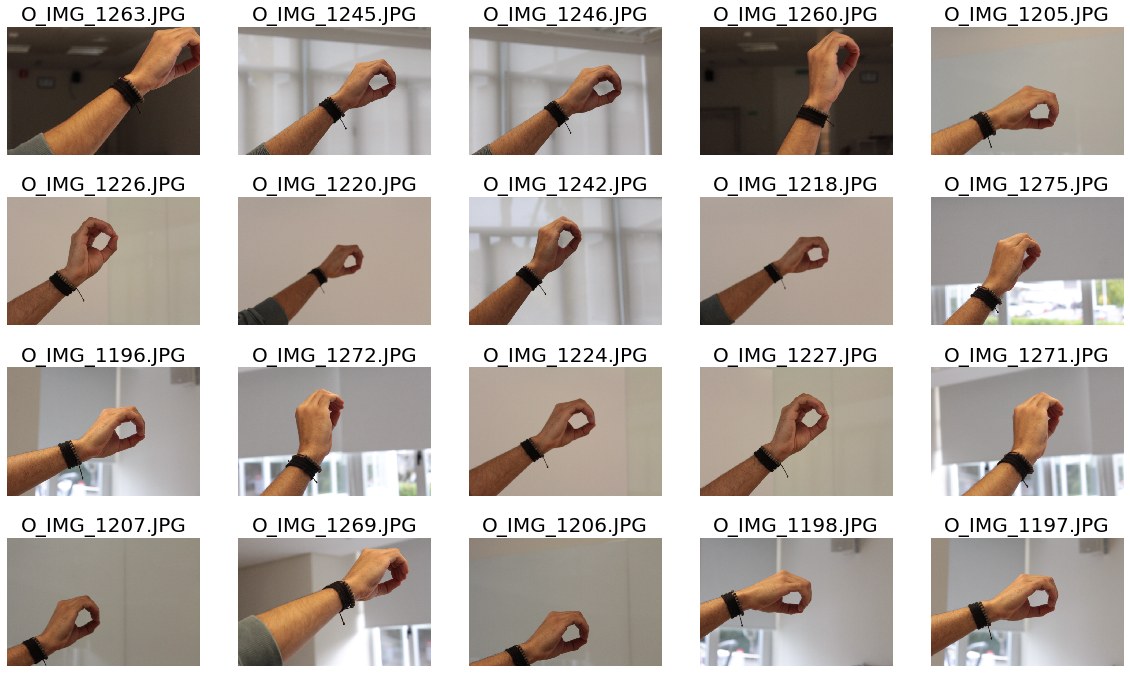

In [5]:
dir_link  = train_dir                            # Link of directory for plotting
dir_label = 'O'                                  # Spesific label for directory
images    = 20                                   # Numbers of images plot
row       = 4                                    # Axes row setting
link      = os.path.join(dir_link, dir_label)    # Full link of images
shape     = {}                                   # Shape of images

fig, ax = plt.subplots(figsize=(20, 12), nrows=row, ncols=images//row)

print(f'Dataset in folder {link}\n')

for i in range(images):
    if images > len(os.listdir(link)):
        print(f"Data in directory is out of number of plot")    
        raise StopExecution
    
    else:
        img_train = plt.imread(os.path.join(link, os.listdir(link)[i]))
        title = dir_label + '_' + os.listdir(link)[i]
        shape[title] = img_train.shape
        
        try:
            ax[i%row,i//row].imshow(img_train)
            ax[i%row,i//row].set_title(title,fontsize=20)
            ax[i%row,i//row].axis('off')
        except:
            pass

print('Shape of Image Data in the folder\n')
shape

In [6]:
# some callbacks for time measurement and early stopping
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") > 0.996:
            print("\nReached 99.6% accuracy so cancelling training!")
            self.model.stop_training = True

time_callback = TimeHistory()
loss_callback = LossCallback()


TRAINING_DIR   = train_dir
VALIDATION_DIR = val_dir
#input_shape    = list(shape.values())[0]
input_shape = (224, 224, 3)
num_classes    = len(label)
print(f"input_shape: {input_shape}")

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

input_shape: (224, 224, 3)
Found 1238 images belonging to 24 classes.
Found 348 images belonging to 24 classes.


Inspect a batch in `training_generator`

In [7]:
for i, train_batch in enumerate(train_generator):
    image_batch, label_batch = train_batch
    
    image_batch = tf.constant(image_batch)
    label_batch = tf.constant(label_batch)
    
    if i == 0:
        break

image_batch.shape

TensorShape([32, 224, 224, 3])

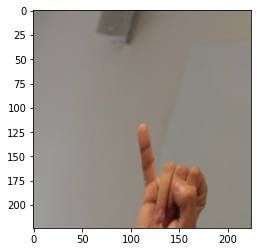

In [8]:
image_batch_ndarray = tf.make_ndarray(tf.make_tensor_proto(image_batch[0]))
plt.imshow(image_batch_ndarray);

In [9]:
label_batch[0]

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

# Create the base model from the pre-trained neuralnets

We will create the base model from **Inception V3** model developed at Google.

In [10]:
# setting layer from transfer model
#local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  # imagenet

# base_model = tf.keras.applications.inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5(input_shape = input_shape, 
#                          include_top = False, 
#                          weights = None)

local_weights_file = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'  # imagenet

base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, 
                                              include_top = False, 
                                              weights = None)

base_model.load_weights(local_weights_file)

In [11]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 1280])

# Feature extraction

## Freeze the convolution base

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Add a classification head

In [14]:
conv2D_layer = tf.keras.layers.Conv2D(32, (5,5), activation='relu')

# testing for a batch
feature_conv2D = conv2D_layer(feature_batch)
print(feature_conv2D.shape)

(32, 3, 3, 32)


In [16]:
dropout_layer = tf.keras.layers.Dropout(0.1)

# testing for a batch
feature_dropout = dropout_layer(feature_conv2D)
print(feature_dropout.shape)

(32, 3, 3, 32)


In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# testing for a batch
feature_batch_average = global_average_layer(feature_dropout)
print(feature_batch_average.shape)

(32, 32)


In [18]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# testing for a batch
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 24)


In [20]:
model = tf.keras.Sequential([
    base_model,
    conv2D_layer,
    dropout_layer,
    global_average_layer,
    prediction_layer
])

## Compile the model

In [21]:
base_learning_rate = 0.01
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 32)          1024032   
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
Total params: 3,282,808
Trainable params: 1,024,824
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
len(model.trainable_variables)

4

## Train the model

In [24]:
initial_epochs = 100
validation_steps = 20
steps_per_epoch = train_len // 32   # the number of samples in our dataset divided by the batch size
validation_steps = val_len // 32    # Total number of steps (batches of samples) to draw before stopping 
                                    # when performing validation at the end of every epoch

loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)

10/10 [==============================] - 5s 520ms/step - loss: 3.1818 - accuracy: 0.0188


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.18
initial accuracy: 0.02


In [26]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_steps=validation_steps,
                    validation_data=validation_generator,
                    callbacks=[time_callback, loss_callback])

Epoch 1/100
38/38 [==============================] - 38s 1s/step - loss: 3.2025 - accuracy: 0.0439 - val_loss: 3.2003 - val_accuracy: 0.0469
Epoch 2/100
38/38 [==============================] - 38s 1s/step - loss: 3.1995 - accuracy: 0.0477 - val_loss: 3.2066 - val_accuracy: 0.0406
Epoch 3/100
38/38 [==============================] - 38s 1s/step - loss: 3.2049 - accuracy: 0.0423 - val_loss: 3.2035 - val_accuracy: 0.0437
Epoch 4/100
38/38 [==============================] - 39s 1s/step - loss: 3.1958 - accuracy: 0.0514 - val_loss: 3.1972 - val_accuracy: 0.0500
Epoch 5/100
38/38 [==============================] - 38s 1s/step - loss: 3.1999 - accuracy: 0.0473 - val_loss: 3.1972 - val_accuracy: 0.0500
Epoch 6/100
38/38 [==============================] - 38s 995ms/step - loss: 3.1991 - accuracy: 0.0481 - val_loss: 3.1972 - val_accuracy: 0.0500
Epoch 7/100
38/38 [==============================] - 37s 986ms/step - loss: 3.2008 - accuracy: 0.0464 - val_loss: 3.2003 - val_accuracy: 0.0469
Epoch 8

KeyboardInterrupt: 

In [ ]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

## Learning curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
num_computed_epochs = len(history.epoch)
print(f"number of computed epochs before the fitting stopped: {num_computed_epochs}")

In [ ]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


for fn in test_path_all:
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    classes_name = np.array(alphabet)
    ##print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
    #print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])

    #print(classes_name[classes[0].argmin()])
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = classes_name[classes[0].argmin()]
    print(f"{fn} is {predicted_label} ({fn_label == predicted_label})")

# Fine tuning

## Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

## Compile the model

In [ ]:
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
               metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

## Continue training the model

In [ ]:
fine_tune_epochs = num_computed_epochs
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         steps_per_epoch=steps_per_epoch,
                         initial_epoch=history.epoch[-1],
                         verbose=1,
                         validation_steps=validation_steps,
                         validation_data=validation_generator,
                         callbacks=[time_callback, loss_callback])

In [ ]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


for fn in test_path_all:
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    classes_name = np.array(alphabet)
    ##print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
    #print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])

    #print(classes_name[classes[0].argmin()])
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = classes_name[classes[0].argmin()]
    print(f"{fn} is {predicted_label} ({fn_label == predicted_label})")